L. Drew Hill

CE263N - Midterm

November 3, 2016

# Short Report

I began by graphically exloring the training data. First, of course, I studied the spatial representations of home price given to us in the example Jupyter notebook. A great deal of spatial correlation appeared to exist among sale price, even when adjusting for total livable area. But I wondered whether other variables may have been confounding this relationship (between geographic location and price or price/TLA). I also wondered whether a seasonal effect existed. To better understand this, I created separate variables for neighborhood, month, and day of the week. 
<br>
    
I created variables to represent "neighborhood" by running DBSCAN on latitude and longitude cooridinates of each home sale and then producing a dummy variable for each neighborhood. -1 ("unassigned") was assigned as the baseline dummy variable, and so was excluded from the analysis. I experimented with eps values between .1 and 0.005 (degrees, as the lat and lon variables were untransformed) and min_samples between 20 and 200. The sweet spot -- assessed by the number of unique neighborhoods produced and a visual examination of the neighborhoods via color-mapped plotting-- seemed to be an eps of 0.05 degrees and 20 samples of 20 or more points. This ultimately produced 18 unique labels with at least 20 houses each. A visual analysis of the neighborhoods (plot using color map) showed decent overlapping with various spatial pricing patterns, as demonstrated by the example code. A an eps of 0.05 degress also makes logical sense (in terms of neighborhoods in suburban America), representing roughly 6 km of Latitude and 4km of Longitude in this part of the world.
<br>


    
I created variables to represent calendar month by assigning the "sale date yymmdd" variable as a string, and then splitting the string into its 4th through 6th characters (month). Dummy variables were then assigned for each month, leaving out January as the baseline dummy. A variable to represent day of the year was created using the "datetime" package, and then converted into dummy variables for each day of the week, omitting monday as the baseline dummy.
<br>


I then graphically explored the bivariate relationships among all variables in the training dataset using a correlation matrix heatmap. DBSCAN labels were considerably related to price. Because many others were also related with price, I determined a simple geospatial regression would not suffice for accurate prediction. Interestingly, sale month and day of the week were almost completely uncorrelated with price.
<br>



Because so many variables appeared potentially useful on their own, but because bivariate relationships are not, by themselves, an unbiased tool for selecting variables to include in a model, I decided to employ a dimensions reduction technique: LASSO, with 10-fold cross-validation and normalization. To test this method, I split the training dataset into 85% train_training and 15% test_training subsets. I ran the LASSO regression on the train_training set and predicted against the test_training subset to find an r2 of 0.78 and an RMSE of 29408. Not terrible!
<br>



But I had a strong urge to learn Random Forests (RF) regression techniques in Python, and so I took another stab with the train_training and test_training subsets of the "training" data to evaluate the predictive power of a Random Forests model. Specifically, I explored Random Forests with 25, 100, 1000, and 5000 estimators and with minimum sample splits at 2, 10, and 50. All RF runs were done using an MSE selection criterion, out of bag sampling in-lieu of cross validation, and 8 processing cores in parallel (hooray sklearn!). 1000 estimators appeared nearly equally as useful as 5000, and only slightly better than 25 or 100; it only took 25 seconds to run which was very tolerable and much better than the 5 minutes it took the 5000 estimator fitting to run, so I ultimately chose to model using 1000 estimators. A minimum split of 2 was substantially better than 10 and 50, and so was chosen as the final split parameter. The Random Forests regression trained on the train_training subset and tested against the test_training subset demonstrated an r2 of 0.91 and an RMSE of 18368. An incredible improvement over the cross-validated LASSO regression. A plot of variable importance within the RF regression demonstrated the greatest importance of TLA, by far, with considerable importance placed on year built, longitude, latitude, and number of rooms. Very little importance was discovered for seasonal, day-of-week, or neighborhood effects.
<br>



Ultimately, both the cross-validated LASSO regression and Random Forests regression models were run on the full (100%) training data set to inform the prediction of the true test data (posted on Kaggle). RMSE values for each model were similar to those produced when fit on the train_training data (85% of the full training set) and tested in the test_training data (15% of the full training set).
<br>



A plot of price values suggested a substanitally log-normal distribution, and so log transformation was considered in each of the above techniques, however, when tested against "test" data, substantially better RMSE were discovered when price was left untransformed-- likely due to the normalization employed in the LASSO regression and the general ability of Random Forests to account very well for non-linearity.

# Code

## Import and spatial analysis

In [293]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from sklearn import linear_model

%matplotlib inline

#CE263N Midterm 2016: House price prediction

In [294]:
# import as pd
data_pd = pd.read_csv('housing_midterm_trn.csv')

#import as array
file = open('housing_midterm_trn.csv', 'rb')
data = np.genfromtxt(file, delimiter=',',skip_header=1)

print(data, data.shape)

(array([[ -8.35856840e+01,   4.16891950e+01,   1.92200000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   2.60000000e+04],
       [ -8.35902220e+01,   4.16744070e+01,   1.93300000e+03, ...,
          0.00000000e+00,   1.00000000e+00,   7.00000000e+04],
       [ -8.37115990e+01,   4.16334100e+01,   1.99700000e+03, ...,
          1.00000000e+00,   0.00000000e+00,   2.49000000e+04],
       ..., 
       [ -8.37260110e+01,   4.16056160e+01,   1.99600000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.89900000e+05],
       [ -8.37055010e+01,   4.16623350e+01,   1.97900000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.68000000e+05],
       [ -8.35781620e+01,   4.16265910e+01,   1.92500000e+03, ...,
          1.00000000e+00,   0.00000000e+00,   3.70000000e+04]]), (20357, 22))


<strong> Data description </strong>

The data contains 20357 records of single family homes sold in Lucas County, Ohio, in 1993-1998. 
There are coordinates, date of sale (derived dummy variable for the year of sale), as well as multiple variables providing essential information about each house. 

###Inputs:

0. longitude
1. latitude
2. yrbuilt, year built
3. stories code,  1=one,2=bilevel,3=multilevel,4=one+half,5=two,6=two+half,7=three
4. TLA, total living area in square feet
5. Wall code,  1=Stucco or Dryvit plaster, 2=Concrete block or tile, 3=Aluminum, vinyl, or steel siding, 4=brick, 5=stone, 6=wood, 7=partial brick
6. \#beds
7. \#baths
8. \#halfbaths
9. frontage
10. garage type code
11. garage sqft
12. \#rooms,  \# of rooms \\
13. lotsize, lot size in square feet
14. sale date yymmdd, date of sale in yymmdd format, e.g., Oct 17, 1997 = 971017
15. sold93, a year of sale dummy, 1=1993
16. sold94, etc.
17. sold95
18. sold96
19. sold97
20. sold98

###Output:

price, selling price ($)


#Initial data exploration

Let's explore the spatial extent of the data.

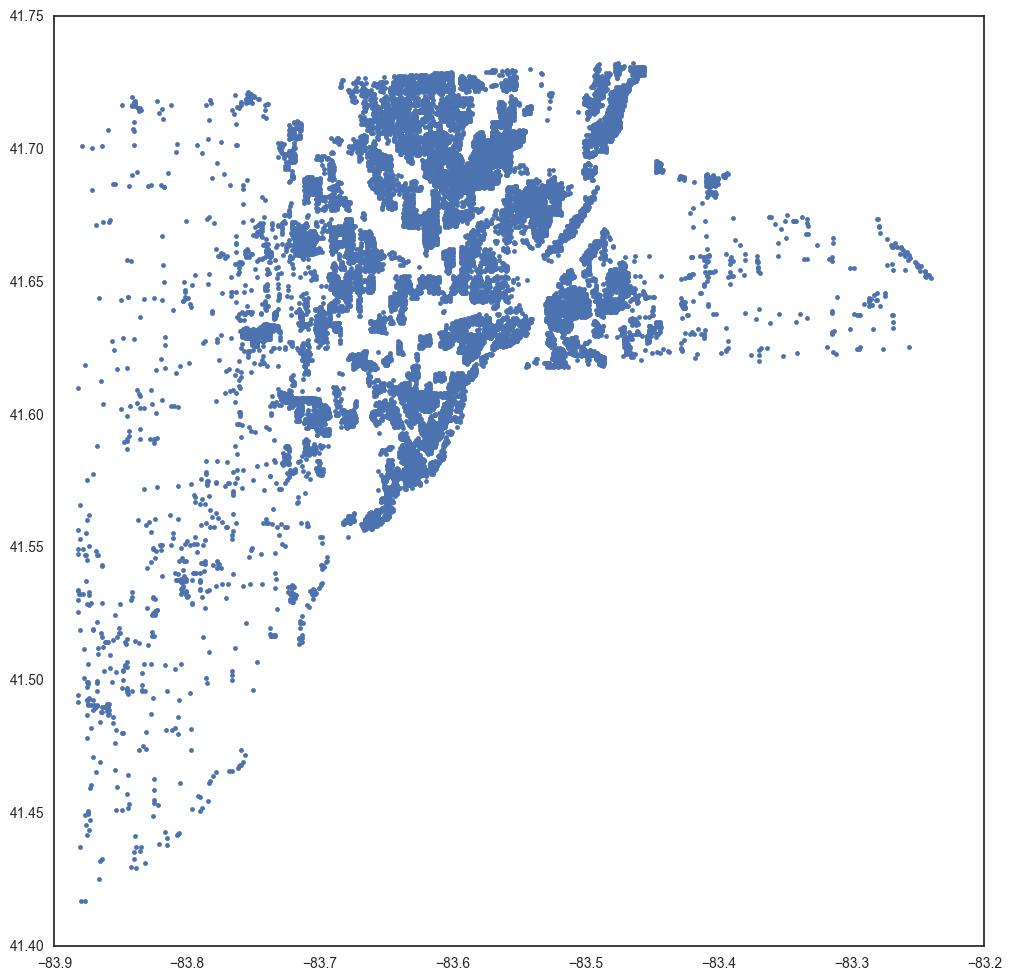

In [295]:
plt.figure(figsize=(12,12))
plt.plot(data[:,0],data[:,1],'.')

<strong> Let's see the same in Google Earth, with house prices and properties. </strong>


(I will only plot 1000 houses cause GEarth will get too slow with the full dataset)

In [296]:
f = open('houses_midterm.kml', 'w')

#Writing the kml file.
f.write("<?xml version='1.0' encoding='UTF-8'?>\n")
f.write("<kml xmlns='http://earth.google.com/kml/2.1'>\n")
f.write("<Document>\n")
f.write("   <name>" + 'houses_midterm.kml' +"</name>\n")
for row in data[:1000]:
    f.write("   <Placemark>\n")
    f.write("       <name>" + str(int(row[-1])) + "</name>\n")
    f.write("       <description>" + 'Year built:   ' + str(int(row[2])) + '\nTLA:  ' + str(int(row[4])) + '\n\n$/sq.ft.:   ' + str(int(float(row[-1])/float(row[4])) )+ "</description>\n")
    f.write("       <Point>\n")
    f.write("           <coordinates>" + str(row[0]) + "," + str(row[1]) + "," + str() + "</coordinates>\n")
    f.write("       </Point>\n")
    f.write("   </Placemark>\n")
f.write("</Document>\n")
f.write("</kml>\n")
f.close()

<strong> Are newly built houses more expensive? <strong>

(0, 400000)

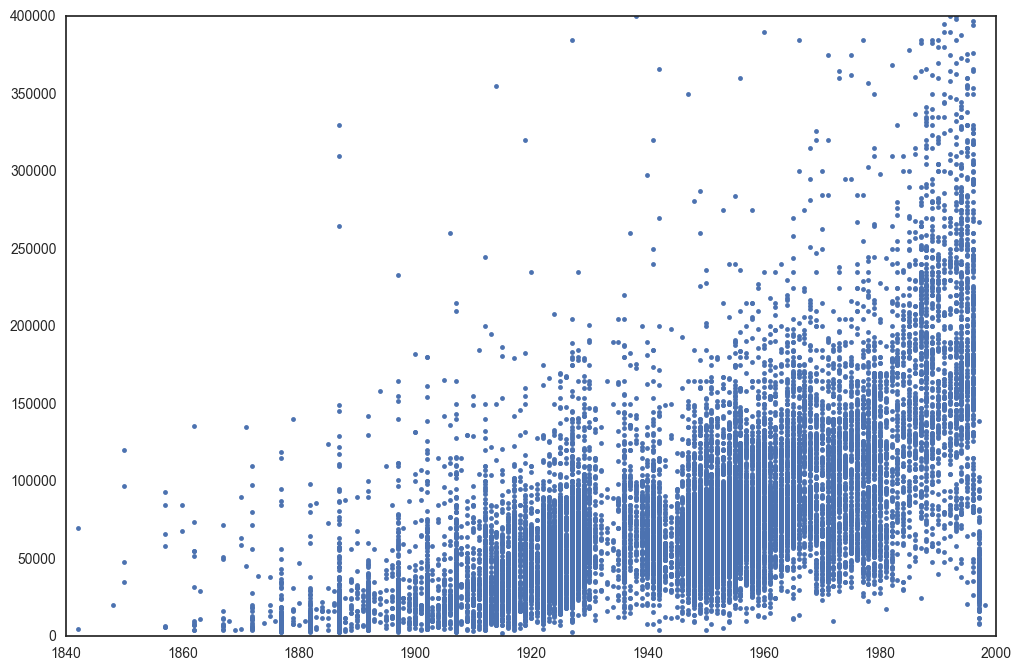

In [297]:
plt.figure(figsize=(12,8))
plt.plot(data[:,2], data[:,-1],'.')

plt.xlim([1840, 2000])
plt.ylim([0, 400000])

<strong> TLA (total living area) is obviously a good predictor of the price too. </strong>

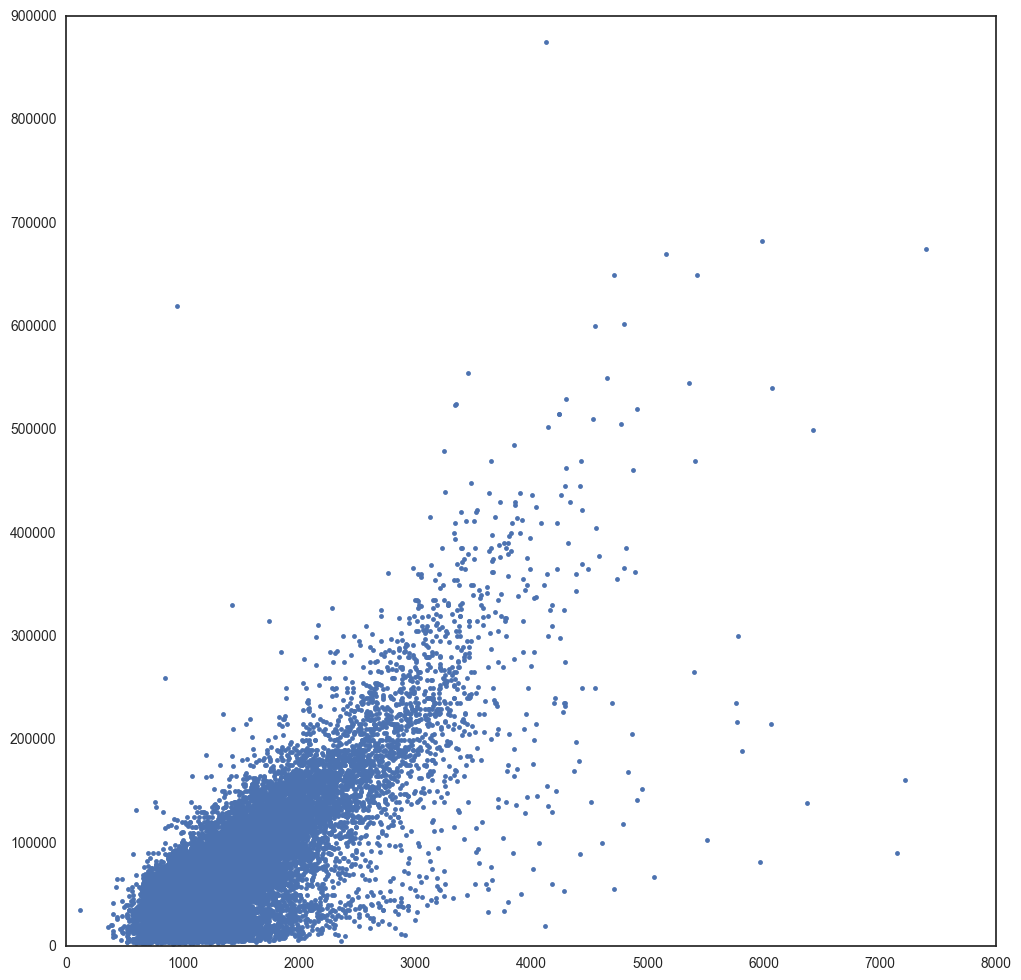

In [298]:
plt.figure(figsize=(12,12))
plt.plot(data[:,4], data[:,-1],'.')

Let's map the $/sq.ft. We will cut off the very high values for now to see the general tendencies.

<strong> The price per sq.ft varies spatially! <strong>

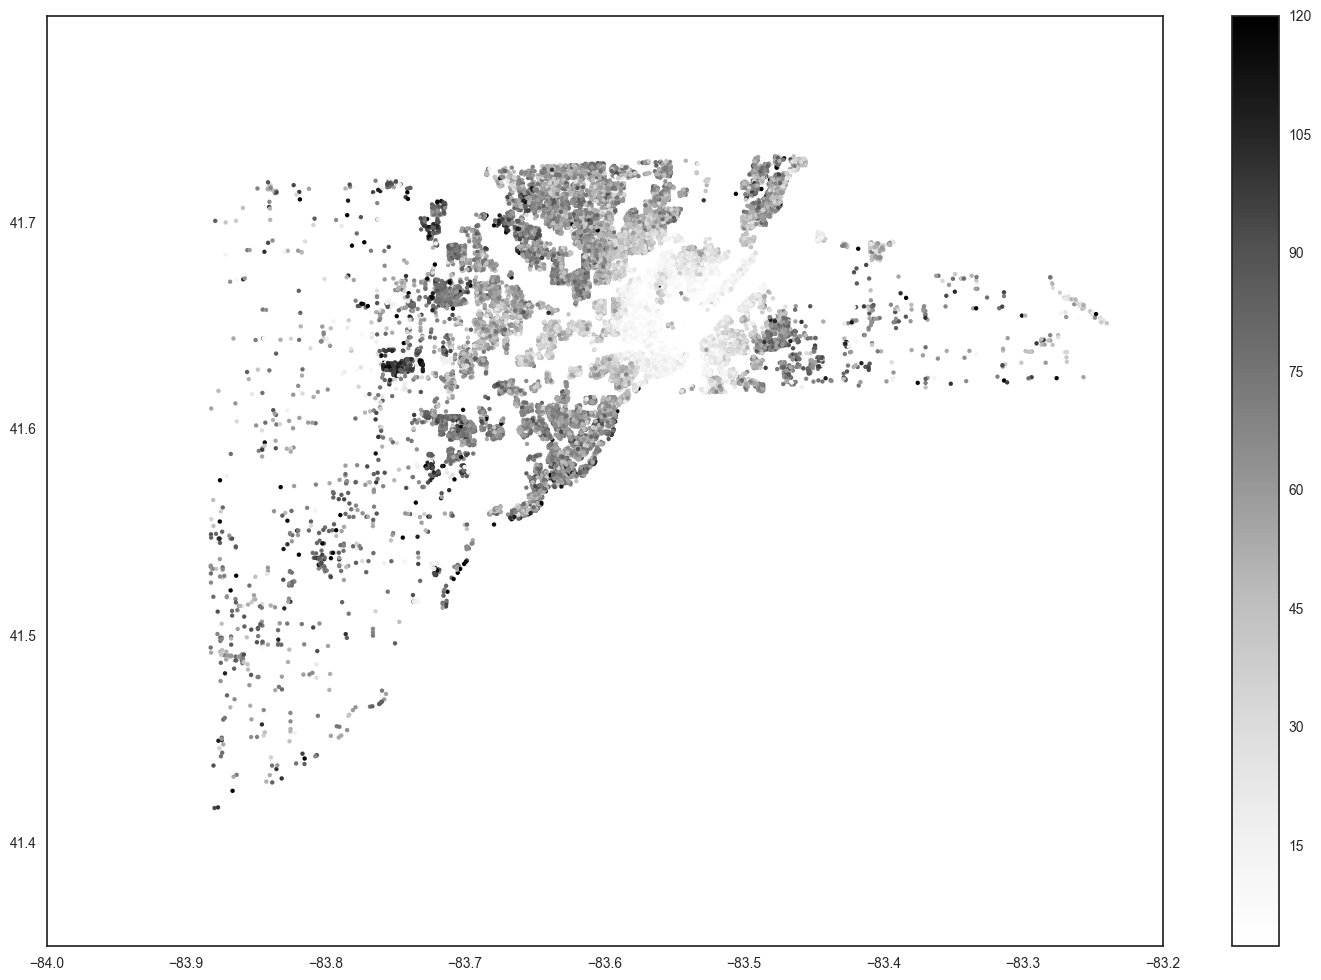

In [299]:
plt.figure(figsize=(18,12))

pptla = data[:,-1]/data[:,4]
pptla[pptla>120] = 120

plt.scatter(data[:,0], data[:,1], s=10, c=pptla, alpha = 1, edgecolors='none')

plt.colorbar()

<strong> Let's map the $ per lot size too. </strong>

Again, we will cut off the very high values for now to see the general tendencies.

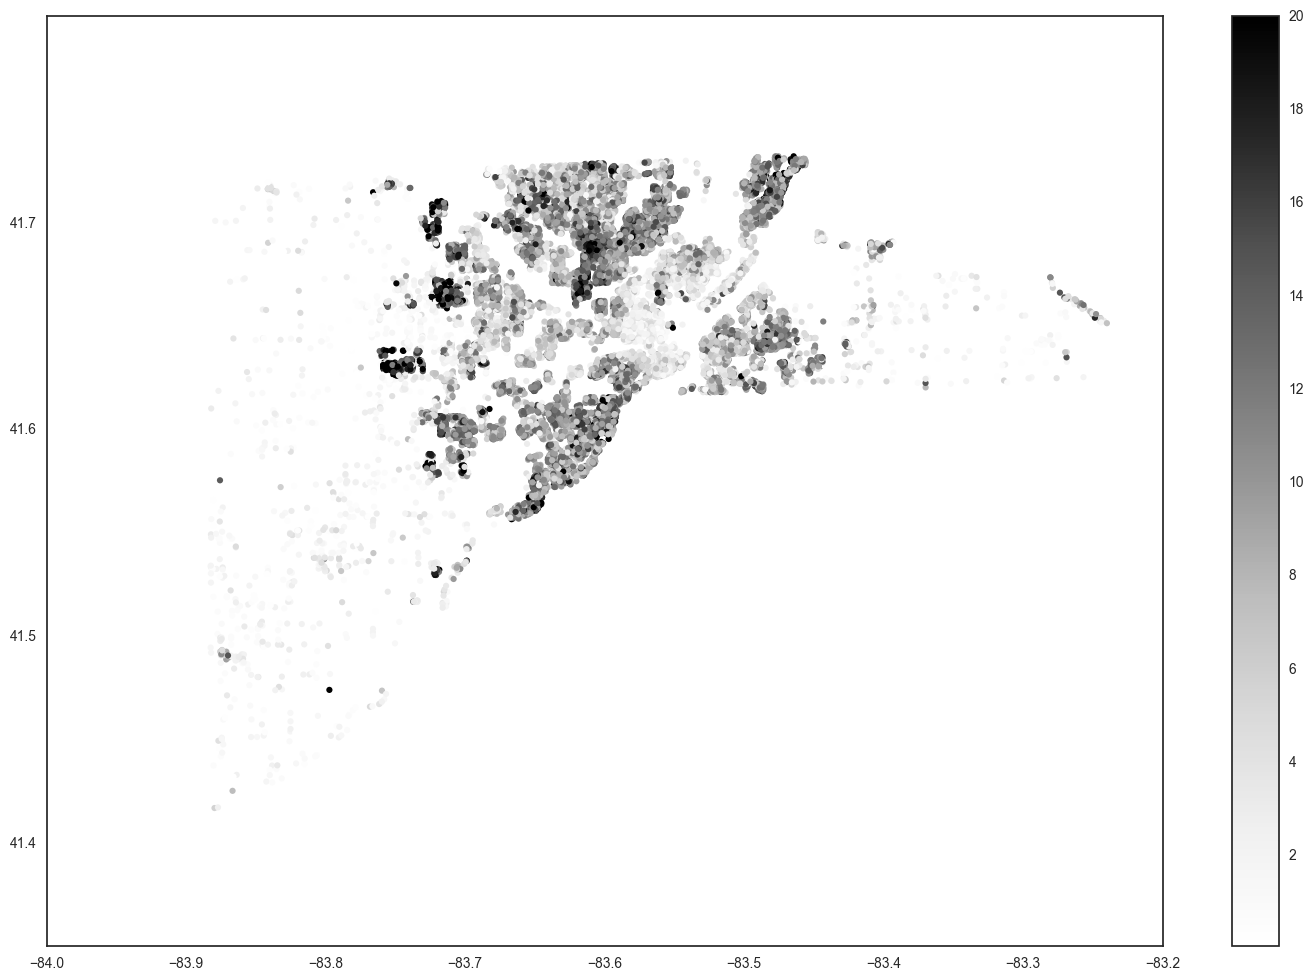

In [300]:
plt.figure(figsize=(18,12))

pplot = data[:,-1]/data[:,13]
pplot[pplot>20] = 20

plt.scatter(data[:,0], data[:,1], s=20, c=pplot, alpha = 1, edgecolors='none')

plt.colorbar()

## My approach

Step 1) Use DBSCAN to produce geospatial clusters based on latitude and longitude; begin to understand neighborhood-type grouping effects

Step 2) Create dummy variable for month of year of sale, day of the week of sale

Step 3) Examine correlation matrix

Step 4) Examine normality of and log-transform outcome

Step 5) Split data into training and testing sets

Step 6) 10-fold cross validated regression, using lasso for dimension reduction

Step 7) Examine test prediction

Step 8) Use random forests (determine optimal # trees ~ 1000)

Step 9) Examine test prediction

In [301]:
###
### Import final test data
###

# pandas
test_pd = pd.read_csv('housing_midterm_test.csv')

#array
file = open('housing_midterm_test.csv', 'rb')
test = np.genfromtxt(file, delimiter=',',skip_header=1)

print(test, test.shape)

(array([[ -8.36055620e+01,   4.16841170e+01,   1.94100000e+03, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -8.36511090e+01,   4.17253300e+01,   1.95800000e+03, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -8.36127080e+01,   4.16970580e+01,   1.94900000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [ -8.35078480e+01,   4.16272370e+01,   1.92200000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -8.36357490e+01,   4.16080770e+01,   1.96500000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -8.36675160e+01,   4.17039770e+01,   1.96700000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]), (5000, 21))


In [302]:
###
### DBSCAN on lat/lon
###
from sklearn.cluster import DBSCAN

## combine full and train data for DBSCAN (lat/lon only)
lat_lon_all = np.vstack([data[:,:2],test[:,:2]])

In [303]:
db = DBSCAN(eps=0.005, min_samples=20).fit(lat_lon_all)
db_labels = db.labels_
db_labels_unique = np.unique(db_labels)
# print unique labels
print 'unique DBSCAN labels:', db_labels_unique

unique DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [304]:
## Add labels to original datasets
data_pd['db_label'] = db_labels[:-5000]
test_pd['db_label'] = db_labels[-5000:]

data = data_pd.as_matrix()
test = test_pd.as_matrix()

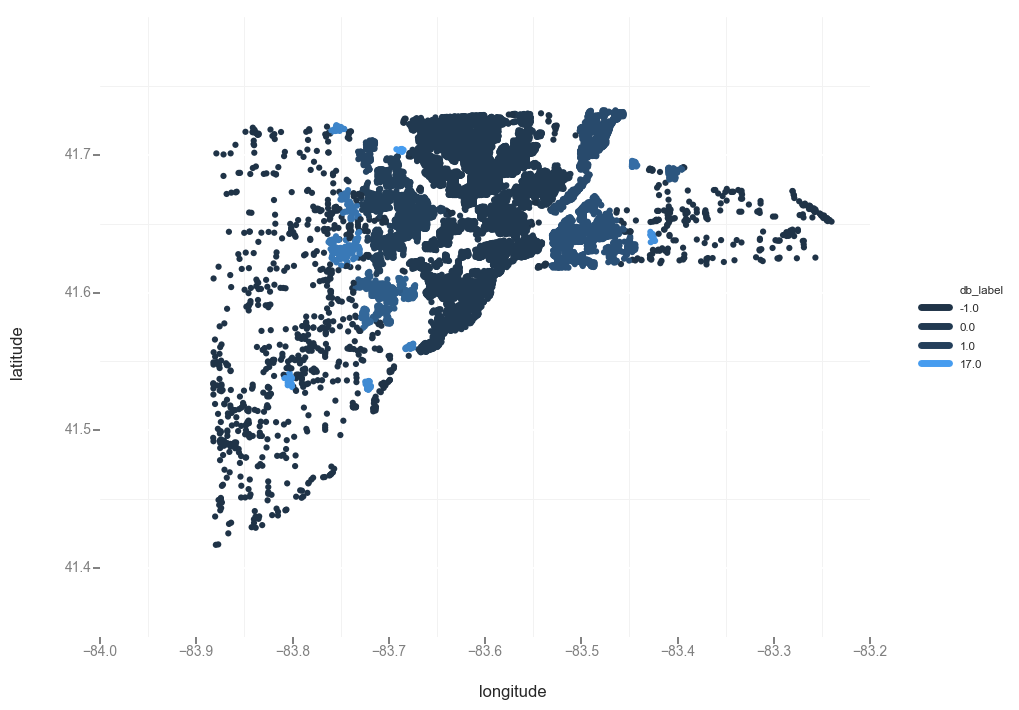

<ggplot: (1081741145)>

In [305]:
## visualize
from ggplot import *

ggplot(test_pd, aes('longitude','latitude',colour='db_label')) + geom_point() + theme_bw()
ggplot(data_pd, aes('longitude','latitude',colour='db_label')) + geom_point() + theme_bw()

In [306]:
# Create Dummy Variable for DBSCAN flag [-1 as baseline]
db_dummies_data = pd.get_dummies(data_pd.db_label, prefix='dblabel_', drop_first=True)
db_dummies_test = pd.get_dummies(test_pd.db_label, prefix='dblabel_', drop_first=True)

# stack side-by-side (cbind)
data_pd = pd.concat([data_pd,db_dummies_data], axis=1)
test_pd = pd.concat([test_pd,db_dummies_test], axis=1)

# drop continuous variables
data_pd = data_pd.drop(['db_label'], axis=1)
test_pd = test_pd.drop(['db_label'], axis=1)

### recreate np array
data = data_pd.as_matrix()
test = test_pd.as_matrix()

In [307]:
###
### create dummy variables for month
###

month = []

for i in range(0,len(data[:,14])):
    a = str(data[i,14])[2:4]
    month.append(a)

# add numeric indicator to dataframe
data_pd['salemonth'] = month

# create dummy variable, January as baseline (dropped dummy)
month_dummies = pd.get_dummies(data_pd.salemonth, prefix='salemonth', drop_first=True)

# stack side-by-side (cbind)
data_pd = pd.concat([data_pd,month_dummies], axis=1)

In [308]:
###
### create dummy variables for day
###
import datetime

date = []

# convert sale date to datetime
for i in range(0,len(data[:,14])):
    a =pd.to_datetime(data_pd['sale date yymmdd'][i], format='%y%m%d')
    date.append(a)

# Convert sale date to day of the week where
# Monday is 0 and Sunday is 6
day = []
for i in range(0,len(date)):
    a = datetime.datetime.weekday(date[i])
    day.append(a)
    
# add numeric indicator to dataframe
data_pd['saleday'] = day

# create dummy variable, monday as baseline (dropped dummy)
day_dummies = pd.get_dummies(data_pd.saleday, prefix='saleday', drop_first=True)

# stack side-by-side (cbind)
data_pd = pd.concat([data_pd,day_dummies], axis=1)

In [309]:
# Move price back to the end for easier indexing and manipoulation
# applies to the training dataset ("data") only
cols = list(data_pd)
cols.insert((len(cols)-1) , cols.pop(cols.index('price')))
data_pd = data_pd.ix[:,cols]
data = data_pd.as_matrix()

# drop extranneous datetime columns
data_pd = data_pd.drop(['sale date yymmdd','salemonth','saleday'], axis=1)

### recreate np array
data = data_pd.as_matrix()

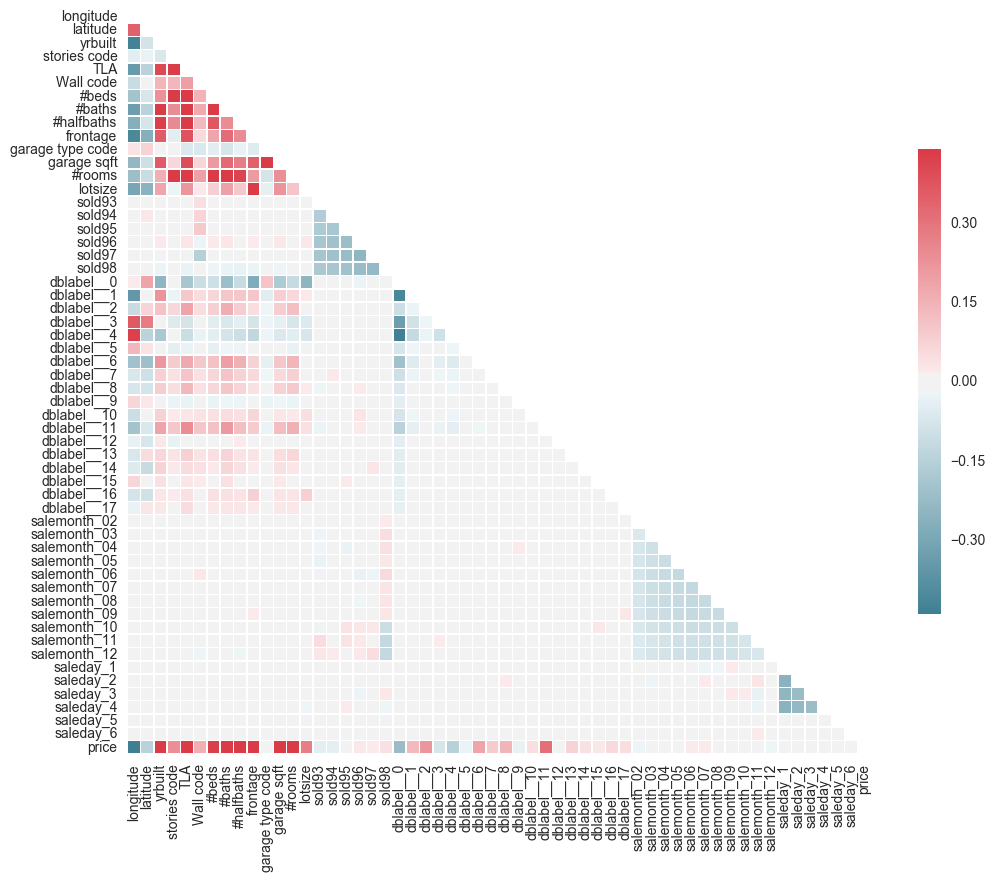

In [310]:
## correlation matrix of all variables
sns.set(style="white")

# create correlation matrix
corr = data_pd.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# setup ticks
plt.xticks(rotation='vertical')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

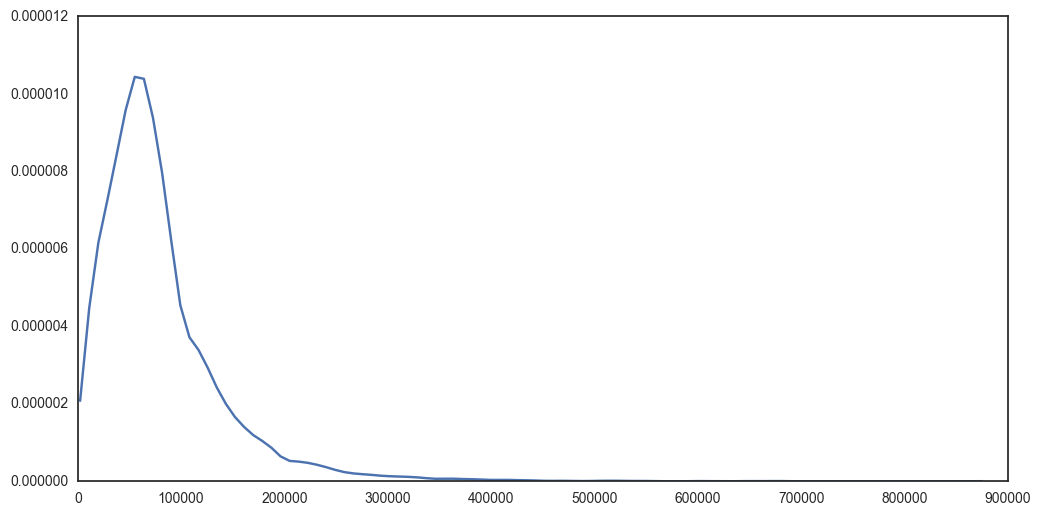

In [323]:
###
### Examine normality of variable (price)
###

from scipy.stats.kde import gaussian_kde

kde = gaussian_kde( data[: , (data.shape[1] - 1)] )
dist_space = np.linspace( min(data[: , (data.shape[1] - 1)]), 
                         max(data[: , (data.shape[1] - 1)]), 100 )
plt.figure(figsize=(12,6))
plt.plot( dist_space, kde(dist_space) )

# ###
# ### Log-transform
# ###

# # log-transform price, based on kernel density plot
# data_pd['price'] = np.log(data_pd['price'])

# # create numpy array
# data = data_pd.as_matrix()

# #

In [311]:
## split into test and train
from sklearn.cross_validation import train_test_split

# split
X_train, X_test, y_train, y_test = \
    train_test_split(data[:,:(data.shape[1] - 1)], 
                     data[:,-1], test_size = 0.15, random_state=0)

predictive r2: 0.7764
predictive RMSE: 29408.4515


[]

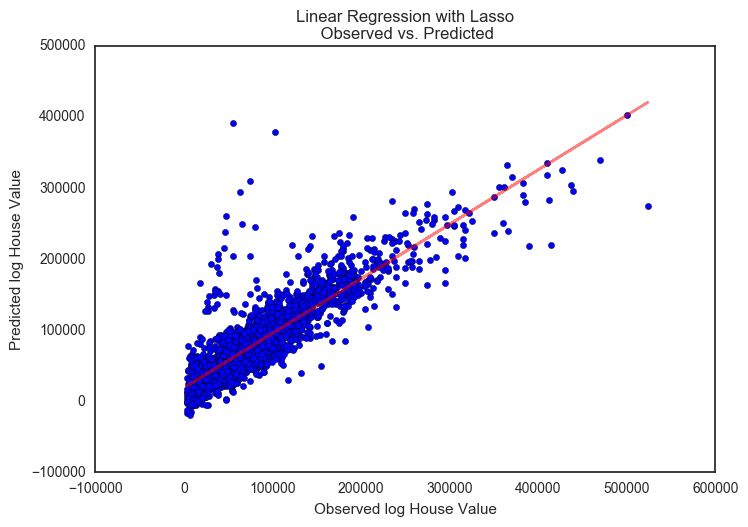

In [312]:
###
### Lasso regression
###

# Linear regression with lasso regularization, normalization, and 10-fold cross valdiation
reg_1 = linear_model.LassoCV(cv=10, normalize=True)
reg_1.fit(X_train, y_train)

# r^2 on test data set
y_bar = sum(y_test) / len(y_test)
SST = sum((y_test-y_bar)**2)
SSReg = sum((reg_1.predict(X_test)-y_bar)**2)
r2 = SSReg/SST
print 'predictive r2:', round(r2,4)

# RMSE on test data set
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_test, reg_1.predict(X_test))**0.5
print 'predictive RMSE:', round(RMSE,4)

# Plot observed vs. predicted
plt.scatter(y_test, reg_1.predict(X_test))
m, b = np.polyfit(y_test, reg_1.predict(X_test), 1)
plt.plot(y_test, m*y_test + b, color='red',alpha=0.5)
# plt.xlim([7,14])
# plt.ylim([7,14])
plt.xlabel('Observed log House Value')
plt.ylabel('Predicted log House Value')
plt.title('Linear Regression with Lasso\n Observed vs. Predicted')

plt.plot()

In [313]:
### Lasso regression on the full training dataset

# Linear regression with lasso regularization, normalization, and 10-fold cross valdiation
reg_full = linear_model.LassoCV(cv=10, normalize=True)
reg_full.fit(data[:,:-1], data[:,-1])

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [265]:
###
### Random Forests
###

### tried 25 trees (r2=0.891), 100 trees (r2=0.896),
### 1000 trees (r2 = 0.896), 5000 trees (r2 = 0.8961)

from sklearn.ensemble import RandomForestRegressor
import time

#initiate RF regression, with 1000 trees, pseudo-CV via out of bag sampling,
# and 8 cores running in parallel
clf = RandomForestRegressor(n_estimators=1000, oob_score=True,
                            criterion='mse', n_jobs=8, random_state=0, 
                           min_samples_split = 2)

# train RF regression
time_clf_start = time.time()
clf.fit(X_train,y_train)
time_clf_stop = time.time()
print 'Dang, this took', time_clf_stop - time_clf_start, 'sec'


# predict on test set
y_test_pred_clf = clf.predict(X_test)



Dang, this took 44.1148808002 sec


In [320]:
## Run RF again for full training dataset
clf_full = RandomForestRegressor(n_estimators=1000, oob_score=True,
                            criterion='mse', n_jobs=8, random_state=0,
                                min_samples_split = 2)

# train RF regression on ALL data
time_clf_start = time.time()
clf_full.fit(data[:,:-1],data[:,-1])
time_clf_stop = time.time()
print 'Dang, this full guy took', time_clf_stop - time_clf_start, 'sec'

Dang, this full guy took 26.3773260117 sec


r2 from random forest regression 0.9057
predictive RMSE from random forest regression: 18368.0946


[]

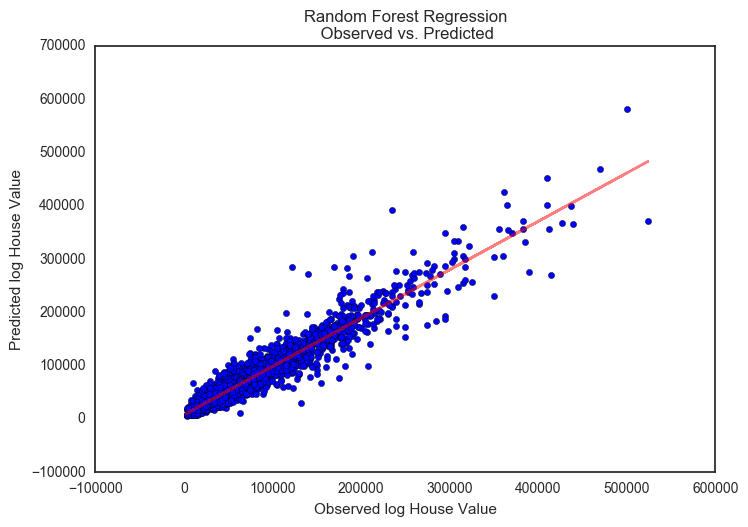

In [266]:
# predictive r2
r2_rf = clf.score(X_test,y_test)

# RMSE on test data set
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_test, clf.predict(X_test))**0.5

print 'r2 from random forest regression', round(r2_rf,4)
print 'predictive RMSE from random forest regression:', round(RMSE,4)

# Plot observed vs. predicted
plt.scatter(y_test, y_test_pred_clf)
m, b = np.polyfit(y_test, y_test_pred_clf, 1)
plt.plot(y_test, m*y_test + b, color='red',alpha=0.5)
# plt.xlim([7,14])
# plt.ylim([7,14])
plt.xlabel('Observed log House Value')
plt.ylabel('Predicted log House Value')
plt.title('Random Forest Regression\n Observed vs. Predicted')

plt.plot()

['longitude', 'latitude', 'yrbuilt', 'stories code', 'TLA', 'Wall code', '#beds', '#baths', '#halfbaths', 'frontage', 'garage type code', 'garage sqft', '#rooms', 'lotsize', 'sold93', 'sold94', 'sold95', 'sold96', 'sold97', 'sold98', 'salemonth_02', 'salemonth_03', 'salemonth_04', 'salemonth_05', 'salemonth_06', 'salemonth_07', 'salemonth_08', 'salemonth_09', 'salemonth_10', 'salemonth_11', 'salemonth_12', 'saleday_1', 'saleday_2', 'saleday_3', 'saleday_4', 'saleday_5', 'saleday_6', 'dblabel__0', 'dblabel__1', 'dblabel__2', 'dblabel__3', 'dblabel__4', 'dblabel__5', 'dblabel__6', 'dblabel__7', 'dblabel__8', 'dblabel__9', 'dblabel__10', 'dblabel__11', 'dblabel__12', 'dblabel__13', 'dblabel__14', 'dblabel__15', 'dblabel__16', 'dblabel__17']


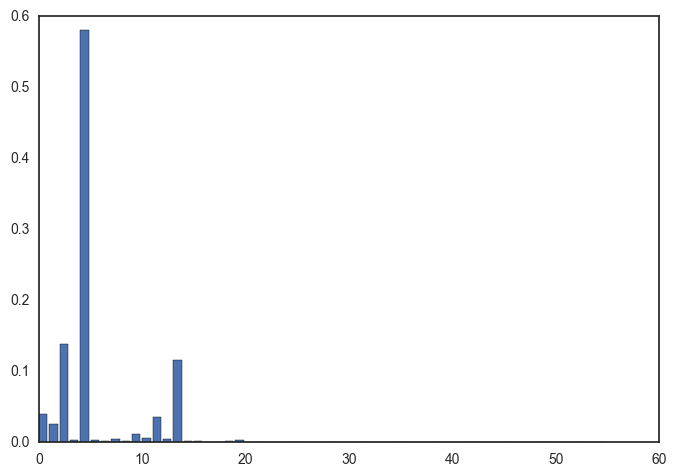

In [262]:
# plot relative importance of variables
import pylab as pl

feature_imp = clf.feature_importances_

fig = pl.figure()
ax = pl.subplot()
ax.bar(xrange(0,(data.shape[1] - 1)), feature_imp)

print list(data_pd.columns.values[:(data.shape[1] - 1)])

<strong> Run Prediction </strong>

In [322]:
###
### create dummy variables for month
###

month = []

for i in range(0,len(test[:,14])):
    a = str(test[i,14])[2:4]
    month.append(a)

# add numeric indicator to testframe
test_pd['salemonth'] = month

# create dummy variable, January as baseline (dropped dummy)
month_dummies = pd.get_dummies(test_pd.salemonth, prefix='salemonth', drop_first=True)

# stack side-by-side (cbind)
test_pd = pd.concat([test_pd,month_dummies], axis=1)


###
### create dummy variables for day
###
import datetime

date = []

# convert sale date to datetime
for i in range(0,len(test[:,14])):
    a =pd.to_datetime(test_pd['sale date yymmdd'][i], format='%y%m%d')
    date.append(a)

# Convert sale date to day of the week where
# Monday is 0 and Sunday is 6
day = []
for i in range(0,len(date)):
    a = datetime.datetime.weekday(date[i])
    day.append(a)
    
# add numeric indicator to testframe
test_pd['saleday'] = day

# create dummy variable, monday as baseline (dropped dummy)
day_dummies = pd.get_dummies(test_pd.saleday, prefix='saleday', drop_first=True)

# stack side-by-side (cbind)
test_pd = pd.concat([test_pd,day_dummies], axis=1)

# drop extranneous datetime columns
test_pd = test_pd.drop(['sale date yymmdd','salemonth','saleday'], axis=1)

# add dummy variables for days 5 and 6, as none exist in the dataset
test_pd['saleday_5'] = np.zeros((5000,1))
test_pd['saleday_6'] = np.zeros((5000,1))

### recreate np array
test = test_pd.as_matrix()

In [321]:
###
### Prediction on the final test set
###

## Linear Regression - split for train/test above
test_pred_l = reg_1.predict(test)

## Linear Regression - full training set
test_pred_lf = reg_full.predict(test)

## Random forests - split for train/test above
test_pred_rf = clf.predict(test)

## Random forests - full training set
test_pred_rff = clf_full.predict(test)

## Create ID variable array
id = np.array(range(0,5000))

## Create final output files, with-exp-converted prices
test_out_l = np.column_stack((id,test_pred_l))
test_out_lf = np.column_stack((id,test_pred_lf))
test_out_rf = np.column_stack((id,test_pred_rf))
test_out_rff = np.column_stack((id,test_pred_rff))

## Save final output files
np.savetxt('test_out_l.csv', test_out_l, delimiter=",", header='id,price', fmt = '%f,%f')
np.savetxt('test_out_lf.csv', test_out_lf, delimiter=",", header='id,price', fmt = '%f,%f')
np.savetxt('test_out_rf.csv', test_out_rf, delimiter=",", header='id,price', fmt = '%f,%f')
np.savetxt('test_out_rff.csv', test_out_rff, delimiter=",", header='id,price', fmt = '%f,%f')